In [1]:
#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("adityajn105/flickr8k")

#print("Path to dataset files:", path)

In [2]:
!pip install -q git+https://github.com/huggingface/peft.git transformers bitsandbytes datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 23.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.8 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently ta

In [3]:
import os
import pandas as pd
from datasets import Dataset, DatasetDict
from PIL import Image
from torchvision import transforms

# Path to the folder containing the images
image_folder = '/kaggle/input/flickr8k/Images/'

# Path to the captions file
captions_file = '/kaggle/input/flickr8k/captions.txt'


# Read the captions file
captions_df = pd.read_csv(captions_file, sep=',', header=None, names=['image', 'caption'])

# Ensure the image paths are correct
captions_df['image_path'] = captions_df['image'].apply(lambda x: os.path.join(image_folder, x))
captions_df = captions_df.iloc[1:].reset_index(drop=True)
# Check the first few rows
captions_df.head()


,image,caption,image_path
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,/kaggle/input/flickr8k/Images/1000268201_693b0...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,/kaggle/input/flickr8k/Images/1000268201_693b0...
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,/kaggle/input/flickr8k/Images/1000268201_693b0...
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,/kaggle/input/flickr8k/Images/1000268201_693b0...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,/kaggle/input/flickr8k/Images/1000268201_693b0...


In [4]:
from sklearn.model_selection import train_test_split

# Split the dataset into train and test (80:20 split)
train_df, test_df = train_test_split(captions_df, test_size=0.2, random_state=42)

# Check the split
print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")


Training set size: 32364
Test set size: 8091


In [5]:
from torch.utils.data import Dataset
from PIL import Image
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")

class Flickr8kDataset(Dataset):
    def __init__(self, dataframe, processor):
        self.dataframe = dataframe
        self.processor = processor

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx]['image_path']
        caption = self.dataframe.iloc[idx]['caption']
        image = Image.open(image_path).convert('RGB')
        return {"image": image, "text": caption}
def collate_fn(batch):
    images = [item["image"] for item in batch]
    texts = [item["text"] for item in batch]

    pixel_values = processor(images=images, return_tensors="pt")["pixel_values"]
    text_inputs = processor.tokenizer(texts, padding="longest", return_tensors="pt", truncation=True)

    return {
        "pixel_values": pixel_values,
        "input_ids": text_inputs["input_ids"],
        "attention_mask": text_inputs["attention_mask"]
    }


2025-05-04 12:23:48.060021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746361428.248537      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746361428.293981      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

In [6]:
from torch.utils.data import DataLoader

train_dataset = Flickr8kDataset(train_df, processor)
test_dataset = Flickr8kDataset(test_df, processor)

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn)


In [7]:
from transformers import Blip2ForConditionalGeneration, Blip2Processor, BitsAndBytesConfig
import torch
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",  # or 'fp4'
    bnb_4bit_compute_dtype=torch.float16
)

model = Blip2ForConditionalGeneration.from_pretrained(
    "ybelkada/blip2-opt-2.7b-fp16-sharded",
    quantization_config=bnb_config,
    device_map="auto"
)


config.json:   0%|          | 0.00/7.05k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

pytorch_model-00004-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00005-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00003-of-00008.bin:   0%|          | 0.00/985M [00:00<?, ?B/s]

pytorch_model-00008-of-00008.bin:   0%|          | 0.00/782M [00:00<?, ?B/s]

pytorch_model-00002-of-00008.bin:   0%|          | 0.00/999M [00:00<?, ?B/s]

pytorch_model-00007-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00006-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00001-of-00008.bin:   0%|          | 0.00/995M [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/127k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [8]:
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
from peft import TaskType


# Configure LoRA
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=[
        'q_proj', 'v_proj', 'k_proj', 'out_proj', 'fc1', 'fc2', 'language_projection'
    ],  # inspect your model for correct target modules
    lora_dropout=0.05,
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 33,071,104 || all params: 3,777,751,040 || trainable%: 0.8754


In [9]:
import torch
from tqdm import tqdm

optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
device    = "cuda" if torch.cuda.is_available() else "cpu"
model.train()

num_epochs = 1

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for batch in loop:

        input_ids      = batch["input_ids"].to(device)
        pixel_values   = batch["pixel_values"].to(device, torch.float16)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(
            input_ids=input_ids,
            pixel_values=pixel_values,
            attention_mask=attention_mask,
            labels=input_ids
        )

        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} final loss: {loss.item():.4f}")


Epoch 1


Epoch 1:   0%|          | 0/10788 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Expanding inputs for image tokens in BLIP-2 should be done in processing. Please follow instruction here (https://gist.github.com/zucchini-nlp/e9f20b054fa322f84ac9311d9ab67042) to update your BLIP-2 model. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.
Epoch 1: 100%|██████████| 10788/10788 [3:19:22<00:00,  1.11s/it, loss=1.9]   

Epoch 1 final loss: 1.8955


In [14]:
from huggingface_hub import notebook_login
notebook_login()


In [15]:
model.push_to_hub("abdullahfaisal9747/Blip-2-Finetuned-Caption-Flick8k")

README.md:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/132M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/abdullahfaisal9747/Blip-2-Finetuned-Caption-Flick8k/commit/728698e040a0fdba4035e2f0cebae0bf301792e6', commit_message='Upload model', commit_description='', oid='728698e040a0fdba4035e2f0cebae0bf301792e6', pr_url=None, repo_url=RepoUrl('https://huggingface.co/abdullahfaisal9747/Blip-2-Finetuned-Caption-Flick8k', endpoint='https://huggingface.co', repo_type='model', repo_id='abdullahfaisal9747/Blip-2-Finetuned-Caption-Flick8k'), pr_revision=None, pr_num=None)

In [16]:
processor.push_to_hub("abdullahfaisal9747/Blip-2-Finetuned-Caption-Flick8k")

CommitInfo(commit_url='https://huggingface.co/abdullahfaisal9747/Blip-2-Finetuned-Caption-Flick8k/commit/c28cbafc47f6bf0c0676b3172351711fe7467d6b', commit_message='Upload processor', commit_description='', oid='c28cbafc47f6bf0c0676b3172351711fe7467d6b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/abdullahfaisal9747/Blip-2-Finetuned-Caption-Flick8k', endpoint='https://huggingface.co', repo_type='model', repo_id='abdullahfaisal9747/Blip-2-Finetuned-Caption-Flick8k'), pr_revision=None, pr_num=None)

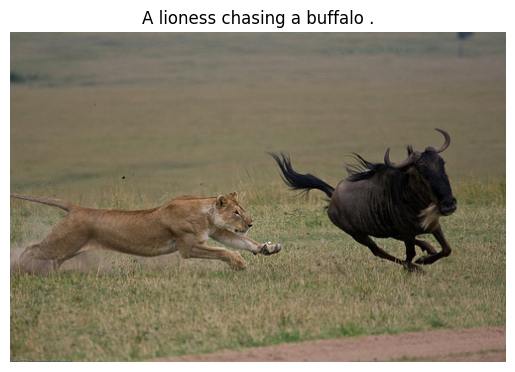

Generated Caption: A lioness chasing a buffalo .


In [17]:
import matplotlib.pyplot as plt

# Set model to eval mode for inference
model.eval()

# Take one sample from the test set
sample = test_df.iloc[0]
image_path = sample['image_path']
image = Image.open(image_path).convert("RGB")

# Preprocess image for inference
inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)

# Generate caption
with torch.no_grad():
    generated_ids = model.generate(
        pixel_values=inputs["pixel_values"],
        max_length=50,
        num_beams=5
    )

# Decode caption
caption = processor.tokenizer.decode(generated_ids[0], skip_special_tokens=True)

# Show image with caption
plt.imshow(image)
plt.axis("off")
plt.title(caption, fontsize=12)
plt.show()

# Optional: also print
print(f"Generated Caption: {caption}")


In [52]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

def caption_image(image_input, model, processor, device, max_length=50, num_beams=5,temperature=1.0):
    """
    Generates and displays a caption for the given image.

    Args:
        image_input (str or PIL.Image): Image path or loaded PIL image.
        model: The fine-tuned BLIP-2 model.
        processor: The corresponding processor.
        device: The torch device (e.g., "cuda" or "cpu").
        max_length (int): Maximum length of the generated caption.
        num_beams (int): Beam search width.

    Returns:
        str: Generated caption.
    """
    model.eval()
    
    # Load image if a path is provided
    if isinstance(image_input, str):
        image = Image.open(image_input).convert("RGB")
    else:
        image = image_input.convert("RGB")

    # Preprocess
    inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)

    # Generate caption
    with torch.no_grad():
        generated_ids = model.generate(
            pixel_values=inputs["pixel_values"],
            max_length=max_length,
            num_beams=num_beams,
            temperature=temperature,
            do_sample=True
        )
    caption = processor.tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    # Show image with caption
    plt.imshow(image)
    plt.axis("off")
    plt.title(caption, fontsize=12)
    plt.show()

    print(f"Generated Caption: {caption}")
    return caption


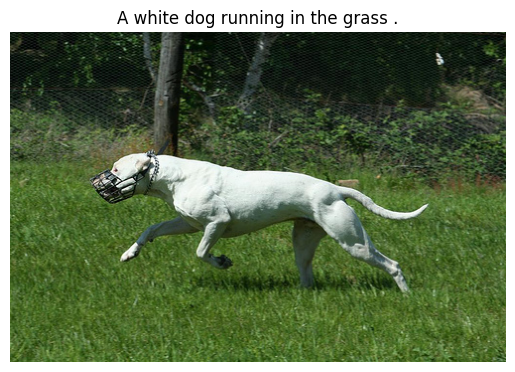

Generated Caption: A white dog running in the grass .


In [54]:
caption = caption_image(test_df.iloc[3]['image_path'], model, processor, device,temperature=0.8)


In [35]:
!pip install nltk

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [42]:
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from torch.utils.data import DataLoader
import torch
from PIL import Image
from transformers import AutoProcessor
from tqdm import tqdm  # Import tqdm for progress bar

# Ensure necessary NLTK resources are downloaded
nltk.download('punkt')

# Define BLEU calculation function (with BLEU-4 specifically)
def calculate_bleu(reference_captions, generated_captions):
    """
    Calculate BLEU-4 score for the generated captions against the reference captions.
    Args:
        reference_captions (list of list of str): List of reference captions (list of words).
        generated_captions (list of str): List of generated captions (strings).
    Returns:
        float: BLEU score.
    """
    # Tokenize reference captions
    reference_tokenized = [nltk.word_tokenize(ref.lower()) for ref in reference_captions]
    
    # Tokenize generated captions
    generated_tokenized = [nltk.word_tokenize(gen.lower()) for gen in generated_captions]

    # Define smoothing function to avoid zero probabilities for rare n-grams
    smoothing_function = SmoothingFunction().method4

    # Calculate BLEU score (using corpus_bleu for multiple references)
    bleu_score = corpus_bleu([[ref] for ref in reference_tokenized], generated_tokenized, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing_function)
    return bleu_score

# Assuming you have the test_loader from your dataset
# Generate captions and calculate BLEU on the test set

def evaluate_bleu(model, processor, device, test_loader, sample_size=50):
    model.eval()
    all_reference_captions = []
    all_generated_captions = []

    # Wrap the test_loader with tqdm for a progress bar
    for batch_idx, batch in tqdm(enumerate(test_loader), desc="Evaluating BLEU Score", unit="batch", total=sample_size // test_loader.batch_size):
        if batch_idx >= sample_size // test_loader.batch_size:  # Limit to 'sample_size' samples
            break

        images = batch["pixel_values"].to(device)
        references = batch["input_ids"]

        # Generate captions for each image
        with torch.no_grad():
            generated_ids = model.generate(
                pixel_values=images,
                num_beams=15,
                do_sample=True
            )
        
        # Decode the generated captions
        generated_captions = [processor.tokenizer.decode(ids, skip_special_tokens=True) for ids in generated_ids]

        # Collect reference captions (convert token IDs back to text)
        for ref_ids in references:
            reference_caption = processor.tokenizer.decode(ref_ids, skip_special_tokens=True)
            all_reference_captions.append(reference_caption)
        
        all_generated_captions.extend(generated_captions)

    # Calculate BLEU-4 score for the selected subset
    bleu_score = calculate_bleu(all_reference_captions, all_generated_captions)
    print(f"BLEU-4 score on 50 test samples: {bleu_score:.4f}")

# Example usage
evaluate_bleu(model, processor, device, test_loader, sample_size=50)


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Evaluating BLEU Score: 100%|██████████| 16/16 [01:12<00:00,  4.52s/batch]

BLEU-4 score on 50 test samples: 0.0700


In [44]:
!pip install evaluate


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.6 MB/s eta 0:00:00


In [65]:
import torch
import pandas as pd
from PIL import Image
import evaluate
from tqdm import tqdm
import os

# Load BLEU metric from the 'evaluate' library
bleu = evaluate.load("bleu")

# Load your test dataframe
# Assuming you have a dataframe `test_df` with 'image_path' and 'caption' columns
subset_df = test_df[:50].reset_index(drop=True)  # Taking first 50 samples for evaluation

# Collect predictions and references
predictions = []
references = {}

# Evaluate predictions for each image in the subset
for idx in range(len(subset_df)):
    row = subset_df.iloc[idx]
    image_name = os.path.basename(row['image_path'])

    # Load the image and preprocess it
    image = Image.open(row['image_path']).convert('RGB')
    inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)

    # Generate caption
    generated_ids = model.generate(pixel_values=inputs.pixel_values, num_beams=15)
    caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # Collect the generated caption
    predictions.append(caption)

    # Collect reference captions (from the dataframe)
    if image_name not in references:
        refs = subset_df[subset_df['image_path'] == row['image_path']]['caption'].tolist()
        references[image_name] = refs

# Now prepare for BLEU calculation
# For each image, we should have one or more references, and a single generated caption.
gt_list = [references[os.path.basename(image_path)] for image_path in subset_df["image_path"]]
pred_list = predictions

# Compute BLEU score using evaluate
bleu_score = bleu.compute(predictions=pred_list, references=gt_list)
print(f"BLEU score for test samples: {bleu_score['bleu']:.4f}")


BLEU score for test samples: 0.2995


In [66]:
!pip install evaluate pycocoevalcap --quiet

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 7.2 MB/s eta 0:00:000:00:010:01
